In [393]:
import torch
import torchvision
import numpy as np
import pandas as pd
from torch.utils.data import Dataset,DataLoader
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch import nn, optim
import torch.nn.functional as F
from torch.autograd import Variable
import os
import matplotlib.pyplot as plt


In [394]:
path = os.getcwd()+'\iris.csv'

In [395]:
dataset = pd.read_csv(path)

label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'species'. 
dataset['variety']= label_encoder.fit_transform(dataset['variety']) 
  
dataset['variety'].unique() 


array([0, 1, 2], dtype=int64)

In [396]:
X = dataset.drop('variety',axis=1)
y = dataset['variety']

In [397]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [398]:
trainset = pd.concat([X_train,y_train],axis=1)
testset = pd.concat([X_test,y_test],axis=1)

In [399]:
class MSRDataset(Dataset):
    def __init__(self,data):
        self.len = data.shape[0]
        self.x_data = torch.from_numpy(data.drop('variety',axis=1).to_numpy()).float()
        self.y_data = torch.from_numpy(data['variety'].to_numpy()).type(torch.LongTensor)
    
    def __getitem__(self,index):
        return self.x_data[index],self.y_data[index]
    
    def __len__(self):
        return self.len

In [400]:
train_data = MSRDataset(trainset)
test_data = MSRDataset(testset)

In [401]:
trainloader = DataLoader(dataset=train_data,batch_size=16,shuffle=True,num_workers=0)
testloader = DataLoader(dataset=test_data,batch_size=16,shuffle=True,num_workers=0)


In [402]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(4, 50)
        self.fc2 = nn.Linear(50, 20)
        self.fc3 = nn.Linear(20, 3)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x),dim=1)
        return x

In [403]:
model = Model()

In [404]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [405]:
N_s = trainset.shape[0] #Nₛ the number of samples in the training data
# batch_size, epoch and iteration
batch_size = 16
n_iters = 8000
num_epochs = n_iters / (N_s / batch_size)
num_epochs = int(num_epochs)
num_epochs

1280

In [406]:
loss_list = []
ite_list = []
accuracy_list = []
count=0
for epoch in range(num_epochs):
    for i,data in enumerate(trainloader):
        inputs,labels = data
        inputs,labels = Variable(inputs),Variable(labels)
        #pdb.set_trace()
        output = model(inputs)
        loss = criterion(output,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count+=1
        #print("loss",loss.data)
        if count %250 == 0:
            loss_list.append(loss.data)
            ite_list.append(count)
            correct = 0
            total = 0
            with torch.no_grad():
                for data in testloader:
                    inputs,labels = data
                    inputs,labels = Variable(inputs),Variable(labels)
                    output = model(inputs)
                    predicted = torch.max(output.data, 1)[1]
                    total += labels.size(0)
                    correct += (predicted == labels).sum()
                    #pdb.set_trace()
            accuracy = 100 * correct / float(total)
            accuracy_list.append(accuracy)
            if count % 500 == 0:
                print('Iteration: {}  Loss: {}  Accuracy: {} %'.format(count, loss.data, accuracy))
        

Iteration: 500  Loss: 0.5866069197654724  Accuracy: 98.0 %
Iteration: 1000  Loss: 0.5558986663818359  Accuracy: 98.0 %
Iteration: 1500  Loss: 0.5567622780799866  Accuracy: 98.0 %
Iteration: 2000  Loss: 0.5522611141204834  Accuracy: 98.0 %
Iteration: 2500  Loss: 0.5760209560394287  Accuracy: 98.0 %
Iteration: 3000  Loss: 0.6307615041732788  Accuracy: 92.0 %
Iteration: 3500  Loss: 0.5515527725219727  Accuracy: 98.0 %
Iteration: 4000  Loss: 0.5515966415405273  Accuracy: 100.0 %
Iteration: 4500  Loss: 0.6180377006530762  Accuracy: 98.0 %
Iteration: 5000  Loss: 0.5563547611236572  Accuracy: 98.0 %
Iteration: 5500  Loss: 0.5515092015266418  Accuracy: 98.0 %
Iteration: 6000  Loss: 0.5777202844619751  Accuracy: 98.0 %
Iteration: 6500  Loss: 0.5629585385322571  Accuracy: 98.0 %
Iteration: 7000  Loss: 0.5528325438499451  Accuracy: 98.0 %
Iteration: 7500  Loss: 0.623670220375061  Accuracy: 98.0 %
Iteration: 8000  Loss: 0.5515069961547852  Accuracy: 98.0 %
Iteration: 8500  Loss: 0.5525204539299011

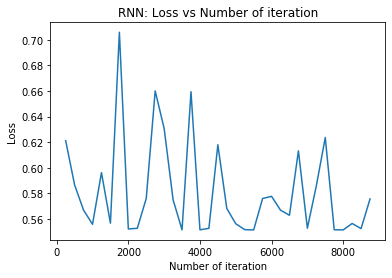

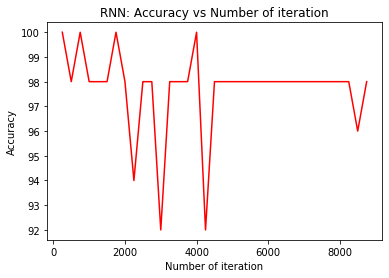

In [407]:
# visualization loss 
plt.plot(ite_list,loss_list)
plt.xlabel("Number of iteration")
plt.ylabel("Loss")
plt.title("RNN: Loss vs Number of iteration")
plt.show()

# visualization accuracy 
plt.plot(ite_list,accuracy_list,color = "red")
plt.xlabel("Number of iteration")
plt.ylabel("Accuracy")
plt.title("RNN: Accuracy vs Number of iteration")
#plt.savefig('graph.png')
plt.show()